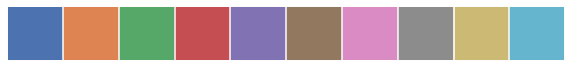

In [439]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set('talk')
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'large',
          'figure.figsize': (16, 9),
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
plt.rcParams.update(params)
import json
from pandas.io.json import json_normalize
current_palette = sns.color_palette()
sns.palplot(current_palette)

def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox.expanded(1.05,1.4))

In [224]:
labels = ['ResNet', 'DenseNet', 'B-ResNet', 'B-DenseNet', 'MSDNet']
models = ['resnet', 'densenet', 'b-resnet', 'b-densenet', 'msdnet']
platforms = ['gpu', 'jetson', 'nuc']

In [225]:
results = {
    platform : {
        model : pd.read_json(platform + '_local_'  + model + '.json') for model in models 
    } for platform in platforms
}

In [226]:
results['nuc']['b-densenet'] = pd.read_json('nuc' + '_local_'  + 'b-densenet' + '2' + '.json')

In [227]:
results['jetson']['b-densenet'] = pd.read_json('jetson' + '_local_'  + 'b-densenet' + '2' + '.json')

In [453]:
results['nuc']['b-resnet']


,exit,prediction,confidence,target,time,correct,sample
0,0,"[0, 44, 95, 60, 8]","[0.135272651910781, 0.07636336982250201, 0.066...",0,45.615730,True,0
1,1,"[0, 60, 76, 91, 44]","[0.7194992899894711, 0.133986100554466, 0.0415...",0,31.443426,True,0
2,2,"[0, 60, 92, 95, 62]","[0.999948978424072, 4.607230221154169e-05, 3.9...",0,125.717888,True,0
3,3,"[0, 60, 62, 95, 92]","[0.9999889135360711, 1.0706169632612723e-05, 3...",0,32.749202,True,0
4,0,"[13, 92, 0, 36, 65]","[0.366111010313034, 0.19254811108112302, 0.183...",0,36.537538,False,1
...,...,...,...,...,...,...,...
19995,3,"[99, 6, 52, 74, 2]","[0.9999369382858271, 2.045917426585219e-05, 1....",99,27.695529,True,4998
19996,0,"[10, 9, 96, 53, 7]","[0.1720822006464, 0.141854539513587, 0.0729288...",99,39.280429,False,4999
19997,1,"[10, 99, 94, 82, 7]","[0.28920716047286904, 0.27947199344635004, 0.0...",99,28.340403,False,4999
19998,2,"[99, 72, 94, 96, 76]","[0.9746101498603821, 0.016700563952326, 0.0049...",99,129.003389,True,4999


In [228]:
stats = {
    platform : {
        model : {} for model in models
    } for platform in platforms
    
}
for platform in platforms:
    for exits, model in zip([1,1,4,4,5], models):
        stats[platform][model]['mean'] = np.cumsum(np.array(results[platform][model][exits:].groupby('exit').time.mean())).tolist()
        stats[platform][model]['std']  = np.cumsum(np.array(results[platform][model][exits:].groupby('exit').time.std())).tolist()
        stats[platform][model]['min']  = np.cumsum(np.array(results[platform][model][exits:].groupby('exit').time.min())).tolist()
        stats[platform][model]['max']  = np.cumsum(np.array(results[platform][model][exits:].groupby('exit').time.max())).tolist()

In [393]:
pd.DataFrame(stats['nuc']['b-densenet'])

,mean,std,min,max
0,28.827130,1.590028,26.047722,41.927834
1,46.706728,2.305259,43.466814,71.851403
2,64.258907,2.801157,60.653512,99.408808
3,72.205878,2.969251,68.371422,112.063739


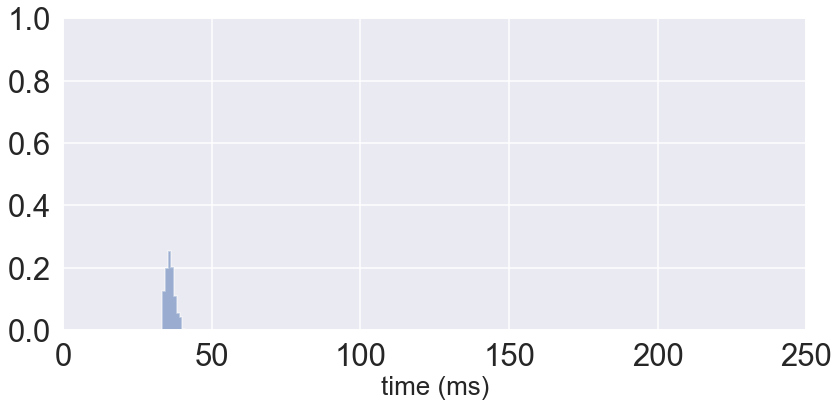

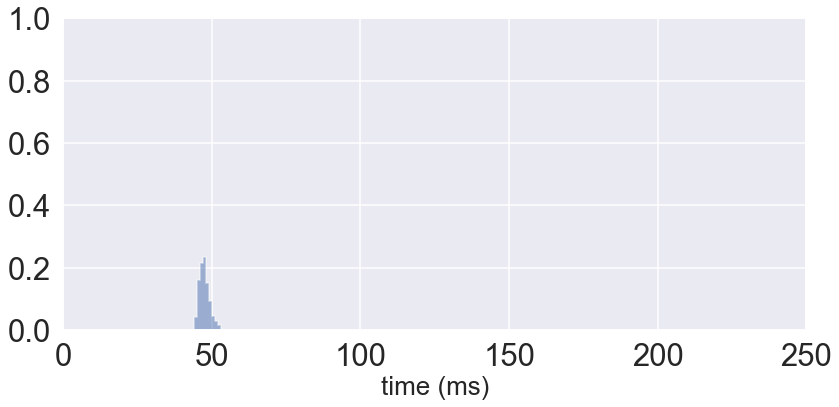

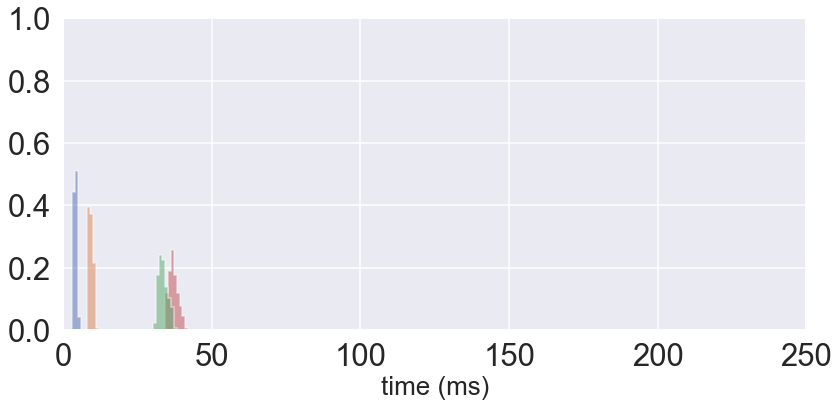

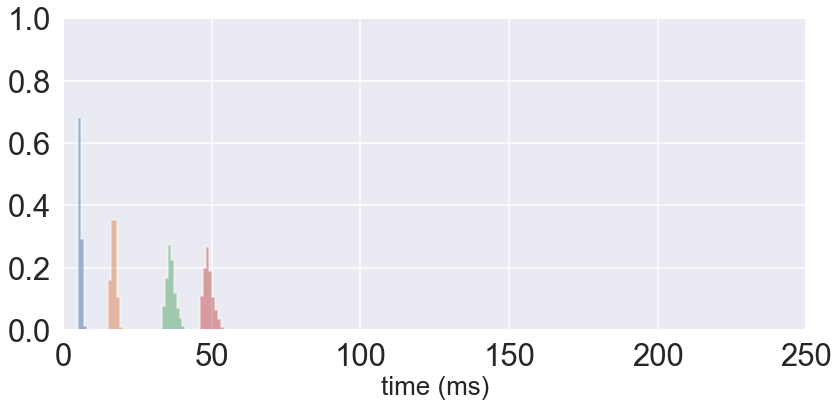

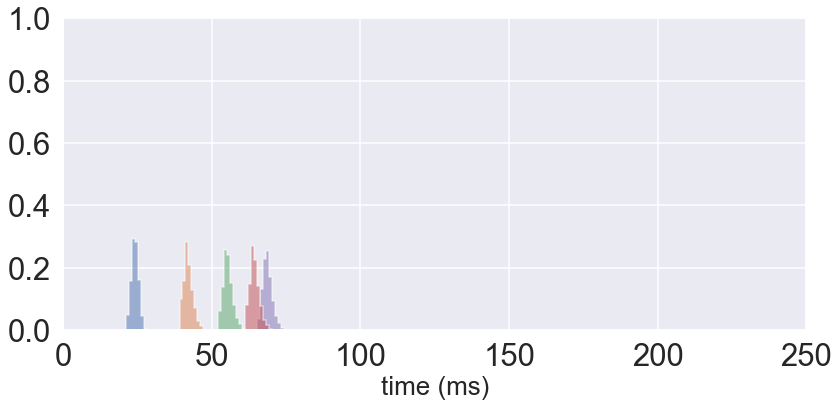

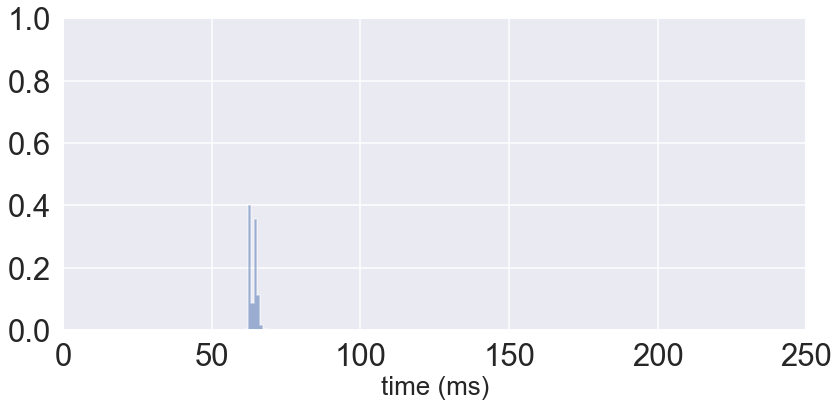

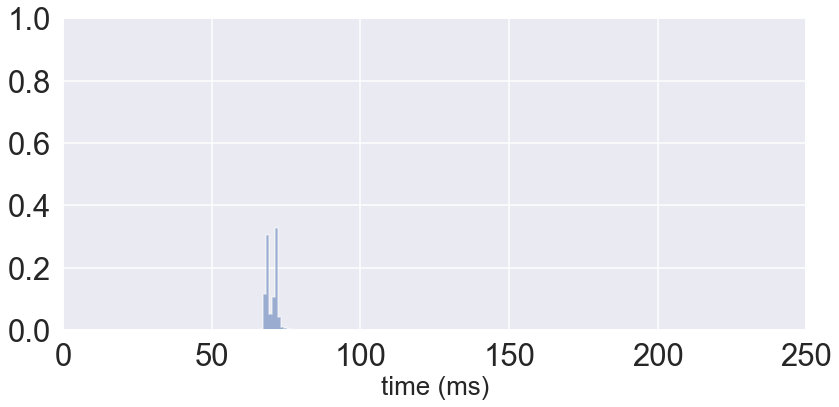

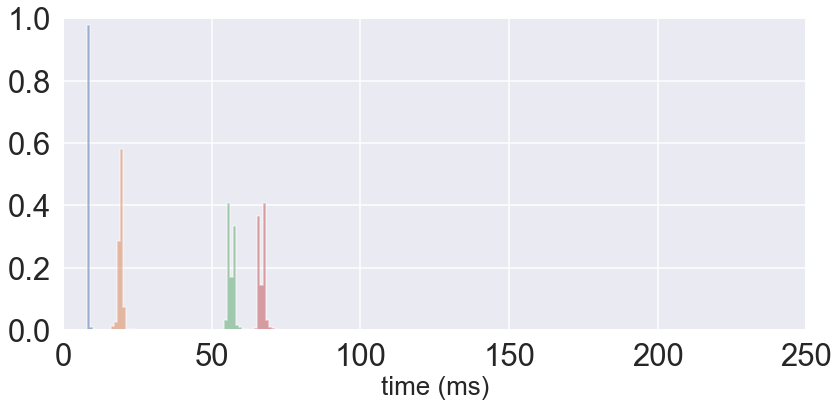

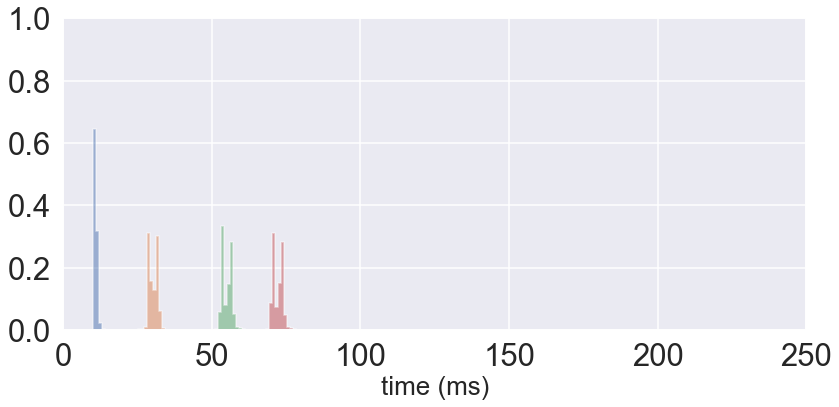

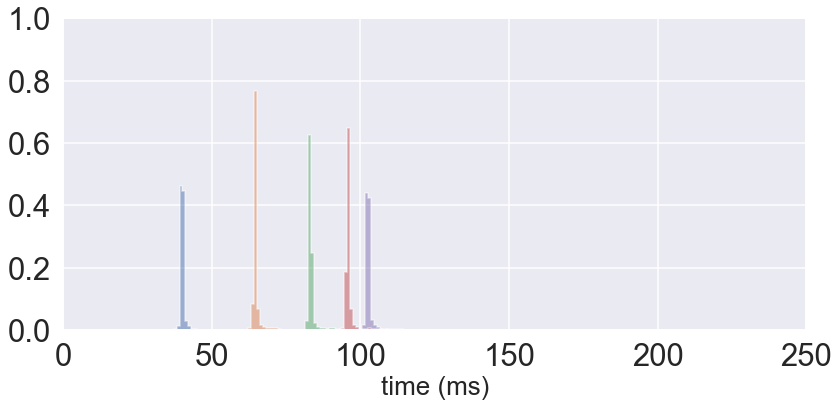

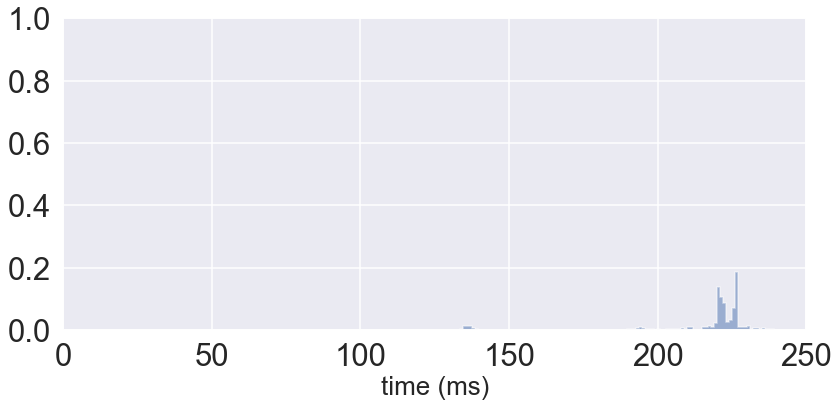

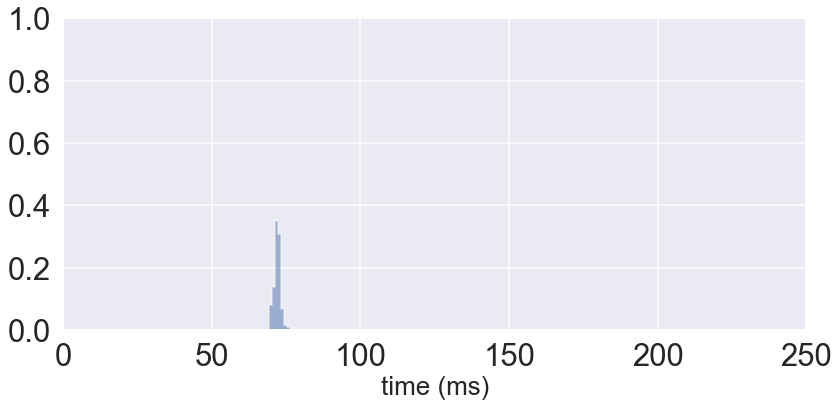

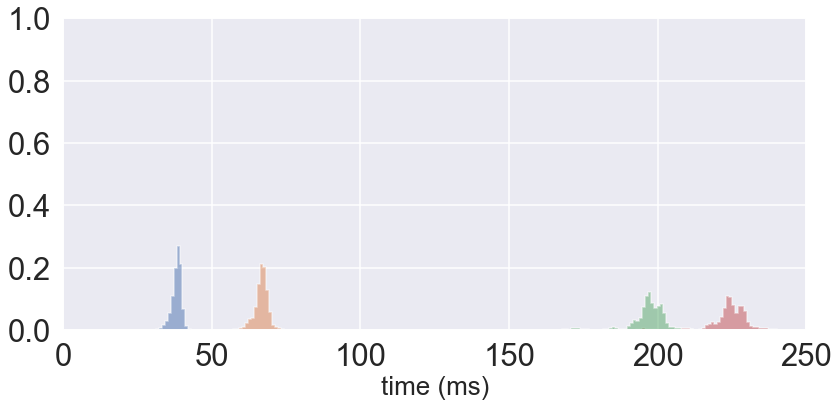

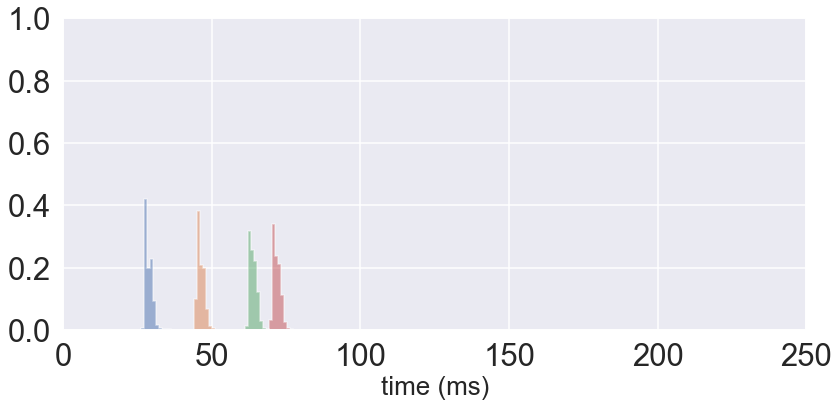

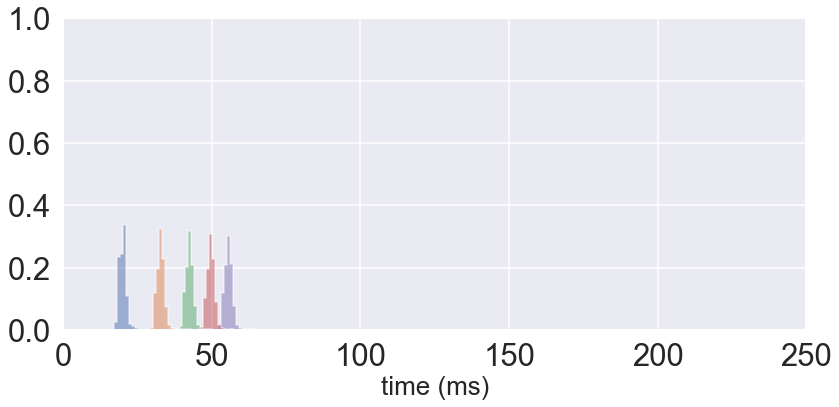

In [230]:
for platform in platforms:
    for model in models:
        fig, axes = plt.subplots(1,1, figsize=(12,6))
        axes.set_xlim([0,250])
        axes.set_ylim([0,1])
        bins = np.linspace(0,250,250)
        
        if model == 'b-resnet' or model == 'b-densenet':
            exits = 4
        elif model == 'msdnet':
            exits = 5
        else:
            exits = 1
            
        time_data = np.zeros((exits,5000))
        for sample, (exit, data) in enumerate(results[platform][model].groupby('exit')):
            time_data[exit]= data.time
        time_data = np.cumsum(time_data, axis=0)
        axes.hist(time_data.T, bins, density=True, histtype='stepfilled',alpha=0.5)

        axes.set_xlabel('time (ms)', fontsize='x-large')
        axes.tick_params(labelsize='xx-large')
        #axes.set_yticks(np.arange(0,1.1,0.25))
        fig.tight_layout()

        plt.savefig(platform + '_' + model + '_inference_time_distribution.png')

In [430]:
results_th = {
    platform : {
        model : pd.read_json(platform + '_local_'  + model + '_analysis.json') for model in models
    } for platform in platforms
}

In [431]:
results_th

{'gpu': {'resnet':      Delay Threshold      Exit     N  latest  missed
  0                  3     [0.0]  5000  0.0000    5000
  1                  4     [0.0]  5000  0.0000    5000
  2                  5     [0.0]  5000  0.0000    5000
  3                  6     [0.0]  5000  0.0000    5000
  4                  7     [0.0]  5000  0.0000    5000
  ..               ...       ...   ...     ...     ...
  262              265  [4999.0]  5000  0.9288       1
  263              266  [4999.0]  5000  0.9288       1
  264              267  [4999.0]  5000  0.9288       1
  265              268  [4999.0]  5000  0.9288       1
  266              269  [4999.0]  5000  0.9288       1
  
  [267 rows x 5 columns],
  'densenet':      Delay Threshold      Exit     N  latest  missed
  0                  3     [0.0]  5000  0.0000    5000
  1                  4     [0.0]  5000  0.0000    5000
  2                  5     [0.0]  5000  0.0000    5000
  3                  6     [0.0]  5000  0.0000    5000
  4    

In [432]:
len(results_th['nuc']['b-resnet'])-len(results_th['nuc']['msdnet'])

0

In [407]:

longest = 0
for model in models[2:5]:
    if len(results_th['nuc'][model]) > longest:
        longest = len(results_th['nuc'][model])

In [415]:
np.array(results_th['nuc'][model]['latest'].tolist())

array([0.    , 0.    , 0.    , 0.0132, 0.1818, 0.35  , 0.6004, 0.6918,
       0.7078, 0.718 , 0.7228, 0.7242, 0.7246, 0.725 , 0.725 , 0.726 ,
       0.7362, 0.7556, 0.7834, 0.8134, 0.821 , 0.8226, 0.8232, 0.8232,
       0.8238, 0.824 , 0.8262, 0.8304, 0.841 , 0.8474, 0.8512, 0.8518,
       0.8526, 0.8532, 0.8538, 0.8586, 0.861 , 0.8634, 0.863 , 0.8632,
       0.8646, 0.8662, 0.8654, 0.8654, 0.8652, 0.865 , 0.8648, 0.8646,
       0.8648, 0.8646, 0.8646, 0.8644, 0.8644, 0.8644, 0.8642, 0.8642,
       0.8642, 0.8642, 0.8644, 0.8644, 0.8644, 0.8644, 0.8642, 0.8642,
       0.8642, 0.8642, 0.8642, 0.864 , 0.864 , 0.864 , 0.864 , 0.864 ,
       0.864 , 0.864 , 0.864 , 0.864 , 0.864 , 0.864 , 0.864 , 0.8642,
       0.8642, 0.8642, 0.8642, 0.8642, 0.8642, 0.8642, 0.864 , 0.864 ,
       0.864 , 0.864 , 0.864 , 0.864 , 0.864 , 0.864 , 0.864 , 0.864 ,
       0.864 , 0.864 , 0.864 , 0.864 , 0.864 , 0.864 , 0.864 , 0.864 ,
       0.864 , 0.864 , 0.864 , 0.864 , 0.864 , 0.864 , 0.864 , 0.864 ,
      

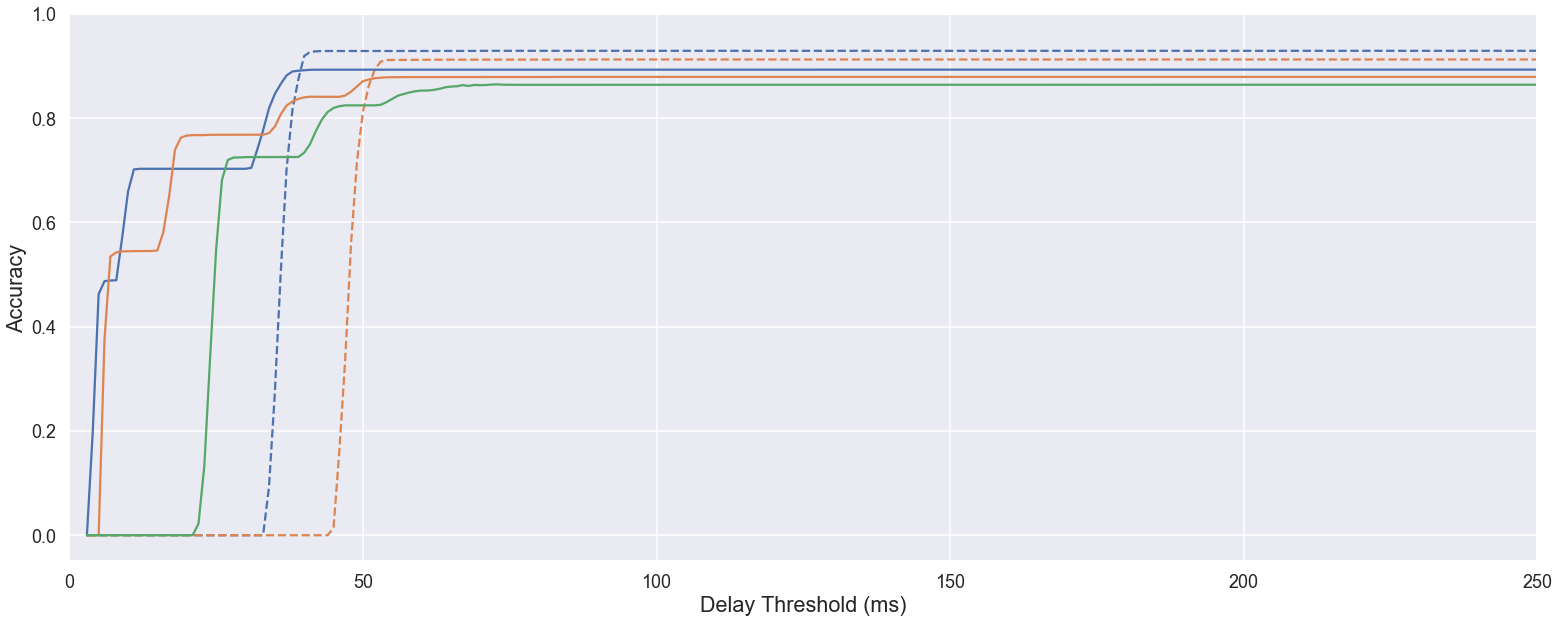

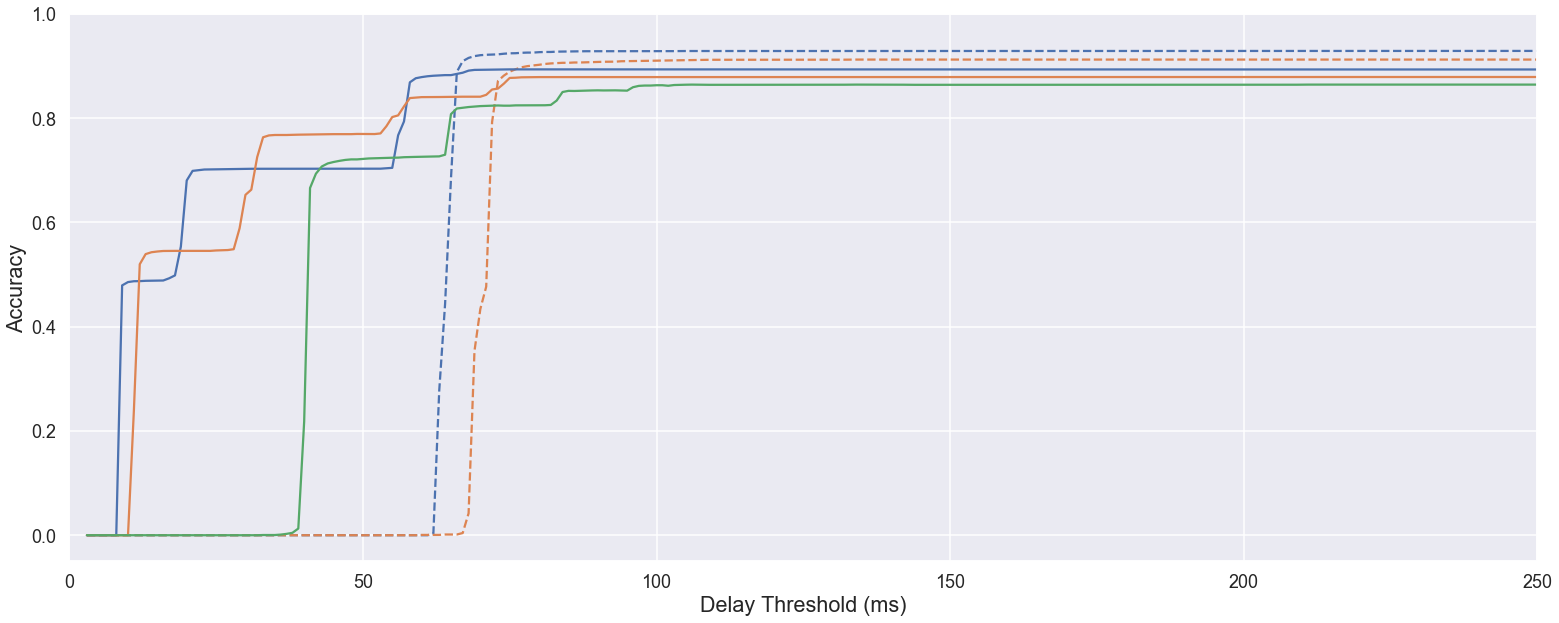

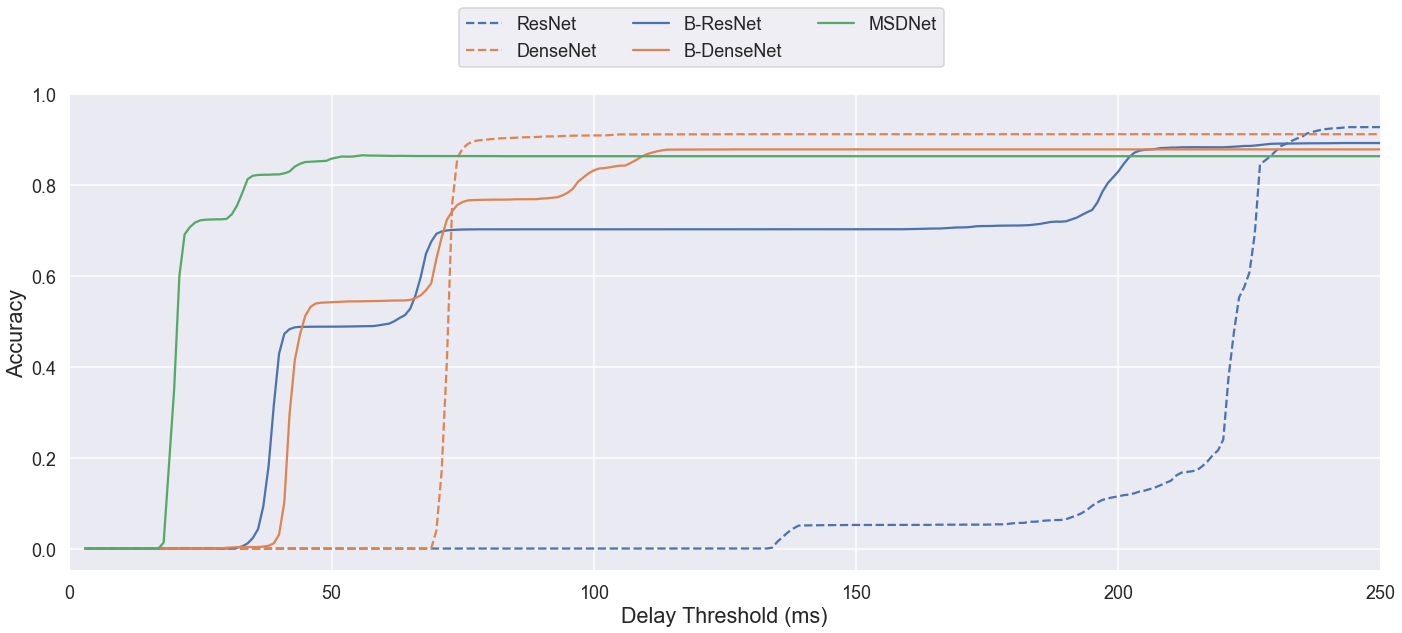

In [452]:
for platform in platforms:
    fig, axes = plt.subplots(1,1, figsize=(22,9))
    for model, color in zip(models[:2],[0,1]):
        axes.plot(results_th[platform][model]['Delay Threshold'],results_th[platform][model]['latest'], '--', color=current_palette[color])
    for model, color in zip(models[2:],[0,1,2]):
        axes.plot(results_th[platform][model]['Delay Threshold'],results_th[platform][model]['latest'], color=current_palette[color])
    axes.set_ylim([-0.05,1])
    axes.set_xlim([-0.1,250])
    axes.set(xlabel='Delay Threshold (ms)', ylabel='Accuracy')
    #fig.legend(ncol=5, 
    #           loc="upper center", fontsize='small')
    fig.tight_layout()
    
    
    plt.savefig(platform + '_' + '_delay_threshold.png')
fig.subplots_adjust(top=0.85, left=0.15)  
legend = fig.legend(labels, ncol=3, loc="upper center", fontsize='medium')
export_legend(legend, filename='delay_threshold_legend.png')

In [454]:
pd.read_json('../edge_test/nuc_2_jetson_b-resnet_time_timing.json')

,sample,exit,time,prediction time
0,0,0,2385.334520,2040.125189
1,0,1,2385.393670,2049.255661
2,0,2,2385.429832,2085.610379
3,0,3,2385.486583,2095.922392
4,1,0,85.715325,8.534085
...,...,...,...,...
19995,4998,3,86.385490,63.346540
19996,4999,0,83.987038,8.567010
19997,4999,1,84.007546,16.811459
19998,4999,2,84.030112,52.725578
